In [2]:
%pip install git+https://github.com/smazzanti/confusion_viz
%pip install --upgrade nbformat

  Cloning https://github.com/smazzanti/confusion_viz to c:\users\czare\appdata\local\temp\pip-req-build-k8h723yn
  Resolved https://github.com/smazzanti/confusion_viz to commit 5ed5d54ff46d566c23edaa5eb4059d2e34af6719
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/smazzanti/confusion_viz 'C:\Users\czare\AppData\Local\Temp\pip-req-build-k8h723yn'

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import warnings
warnings.filterwarnings("ignore")

In [4]:
radiomic_features_df = pd.read_table('Data\clinical_radiomics.tsv')

In [5]:
#Clean up
radiomic_features_df = radiomic_features_df[radiomic_features_df.OS_cens == '0']

radiomic_features_df["OS_result"] = radiomic_features_df["OS"] > 2.15 if 'long' else 'short'
radiomic_features_df = radiomic_features_df.drop(columns=["Image","Mask","type","CT_drugs","Treatment", "intent", "Metastasis_location", 
                                                          "diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy",
                                                          "diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet",
                                                          "diagnostics_Versions_Python","diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes",
                                                          "diagnostics_Image.original_Hash", "diagnostics_Image.original_Dimensionality", "diagnostics_Image.original_Spacing",
                                                          "diagnostics_Image.original_Minimum", "OS_cens","diagnostics_Image.original_Minimum", "OS", "diagnostics_Mask.original_Hash",
                                                          "diagnostics_Mask.original_Spacing", "diagnostics_Mask.original_BoundingBox",	"diagnostics_Mask.original_VoxelNum", "N",
                                                          "diagnostics_Mask.original_Size",  "diagnostics_Image.original_Size", "diagnostics_Mask.original_CenterOfMassIndex",	"diagnostics_Mask.original_CenterOfMass",
                                                          "CT_effect", "zubrod_score", "T", "HT", "PLT", "RBC", "WBC", "ID", "MFS","MFS_cens","CT_cycles", "histopathology", "location",
                                                           "MIP","RT_fractional_dose", "HB"])


In [39]:
X = radiomic_features_df.loc[:,radiomic_features_df.columns != "OS_result"]  #independent columns
y = radiomic_features_df.loc[:,radiomic_features_df.columns == "OS_result"]    #target column i.e price range

df1 = pd.get_dummies(X['sex'])
X = pd.concat([X, df1], axis=1).reindex(X.index)
X.drop('sex', axis=1, inplace=True)
std_slc = StandardScaler()

y = np.ravel(y)
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=15)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

data = pd.DataFrame(std_slc.fit_transform(dfscores), columns=dfscores.columns, index=dfscores.index)
featureScores = pd.concat([dfcolumns,data],axis=1)
featureScores.columns = ['Specs','Score'] 
print(featureScores)
#featureScores = featureScores. = ['Specs','Score']  #naming the dataframe columns

                                   Specs     Score
0                                    age -0.700593
1                          RT_total_dose -0.445824
2        diagnostics_Image.original_Mean -0.700593
3     diagnostics_Image.original_Maximum -0.700593
4    diagnostics_Mask.original_VolumeNum  0.493763
..                                   ...       ...
107            original_ngtdm_Complexity -0.147294
108              original_ngtdm_Contrast  0.634201
109              original_ngtdm_Strength -0.700593
110                               FEMALE -0.700593
111                                 MALE  0.857694

[112 rows x 2 columns]


In [40]:

features = featureScores.nlargest(15,'Score')['Specs']
print(features)
five_first_features = X[features [:5]] #first 5 features
five_ten_features = X[features [:10]] #first 10 features
fifteen_features = X[features] #15 features

32            original_firstorder_RootMeanSquared
97            original_gldm_HighGrayLevelEmphasis
27                       original_firstorder_Mean
21                     original_firstorder_Energy
34                original_firstorder_TotalEnergy
50                             original_glcm_Imc2
37                  original_glcm_Autocorrelation
28                     original_firstorder_Median
64    original_glrlm_LongRunHighGrayLevelEmphasis
16                     original_shape_SurfaceArea
8                  original_shape_MajorAxisLength
72                original_glrlm_ShortRunEmphasis
30                      original_firstorder_Range
40                     original_glcm_ClusterShade
20               original_firstorder_90Percentile
Name: Specs, dtype: object



5 features
[[0.79506003 0.20493997]
 [0.79538285 0.20461715]
 [0.7951439  0.2048561 ]]
0.7972222222222223 {'logistic_Reg__C': 0.0001, 'logistic_Reg__penalty': 'l2', 'pca__n_components': 1}
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]




Text(0.5, 1.0, 'Results')

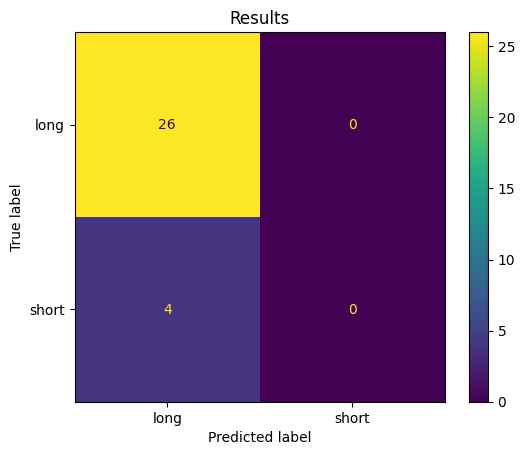

In [41]:
print("\n5 features")
X_train,X_test,y_train,y_test = train_test_split(five_first_features,y,test_size = 0.4, random_state = 0)
pca = decomposition.PCA()
std_slc = StandardScaler()
model = LogisticRegression()
pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('pca', pca),
                           ('logistic_Reg', model)])

cv = KFold(n_splits=10,shuffle=True)
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']
n_components = list(range(1,X.shape[1]+1,1))
parameters = dict(pca__n_components=n_components,
                      logistic_Reg__C=C,
                      logistic_Reg__penalty=penalty)
grid_search = GridSearchCV(pipe, parameters)

grid_search.fit(X_train, y_train)
predicted_probs =grid_search.predict_proba(X_test)
print(predicted_probs[0:3])
print (grid_search.best_score_, grid_search.best_params_) 
y_pred = grid_search.predict(X_test)
print(y_pred)
print('\n')
disp = ConfusionMatrixDisplay.from_predictions(
       y_test,y_pred,display_labels=["long","short"]
    )
disp.ax_.set_title("Results")


10 features
[[0.49514012 0.50485988]
 [0.91329732 0.08670268]
 [0.70953644 0.29046356]]
0.8638888888888889 {'logistic_Reg__C': 0.5689866029018293, 'logistic_Reg__penalty': 'l2', 'pca__n_components': 2}
[ True False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False]




Text(0.5, 1.0, 'Results')

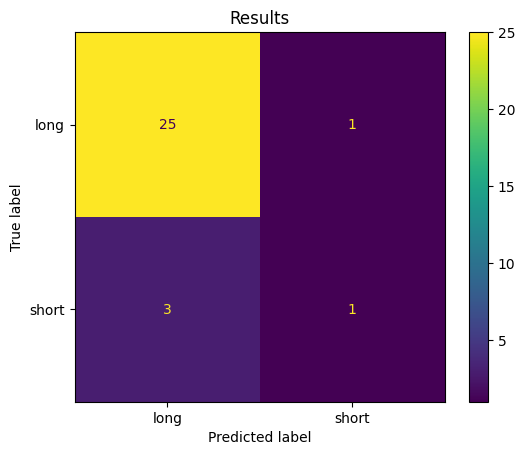

In [ ]:
print("\n10 features")
X_train,X_test,y_train,y_test = train_test_split(five_ten_features,y,test_size = 0.4, random_state = 0)
pca = decomposition.PCA()
std_slc = StandardScaler()
model = LogisticRegression()
pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('pca', pca),
                           ('logistic_Reg', model)])

cv = KFold(n_splits=10,shuffle=True)
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']
n_components = list(range(1,X.shape[1]+1,1))
parameters = dict(pca__n_components=n_components,
                      logistic_Reg__C=C,
                      logistic_Reg__penalty=penalty)
grid_search = GridSearchCV(pipe, parameters)

grid_search.fit(X_train, y_train)
predicted_probs =grid_search.predict_proba(X_test)
print(predicted_probs[0:3])
print (grid_search.best_score_, grid_search.best_params_) 
y_pred = grid_search.predict(X_test)
print(y_pred)
print('\n')
disp = ConfusionMatrixDisplay.from_predictions(
       y_test,y_pred,display_labels=["long","short"]
    )
disp.ax_.set_title("Results")


15 features
[[0.36839572 0.63160428]
 [0.89528696 0.10471304]
 [0.6143139  0.3856861 ]]
0.8638888888888889 {'logistic_Reg__C': 1.2067926406393288, 'logistic_Reg__penalty': 'l2', 'pca__n_components': 1}
[ True False False False False False False False False False False False
 False False False False False False  True False  True False False False
 False False False False False False]




Text(0.5, 1.0, 'Results')

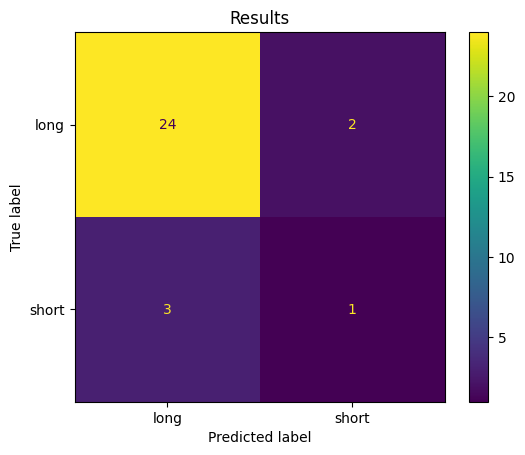

In [ ]:
print("\n15 features")
X_train,X_test,y_train,y_test = train_test_split(fifteen_features,y,test_size = 0.4, random_state = 0)
pca = decomposition.PCA()
std_slc = StandardScaler()
model = LogisticRegression()
pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('pca', pca),
                           ('logistic_Reg', model)])

cv = KFold(n_splits=10,shuffle=True)
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']
n_components = list(range(1,X.shape[1]+1,1))
parameters = dict(pca__n_components=n_components,
                      logistic_Reg__C=C,
                      logistic_Reg__penalty=penalty)
grid_search = GridSearchCV(pipe, parameters)

grid_search.fit(X_train, y_train)
predicted_probs =grid_search.predict_proba(X_test)
print(predicted_probs[0:3])
print (grid_search.best_score_, grid_search.best_params_) 
y_pred = grid_search.predict(X_test)
print(y_pred)
print('\n')
disp = ConfusionMatrixDisplay.from_predictions(
       y_test,y_pred,display_labels=["long","short"]
    )
disp.ax_.set_title("Results")

[[0.88815361 0.11184639]
 [0.62670708 0.37329292]
 [0.47521501 0.52478499]]
0.8388888888888889 {'logistic_Reg__C': 0.05963623316594643, 'logistic_Reg__penalty': 'l2', 'pca__n_components': 15}
[False False  True False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False]




Text(0.5, 1.0, 'Results')

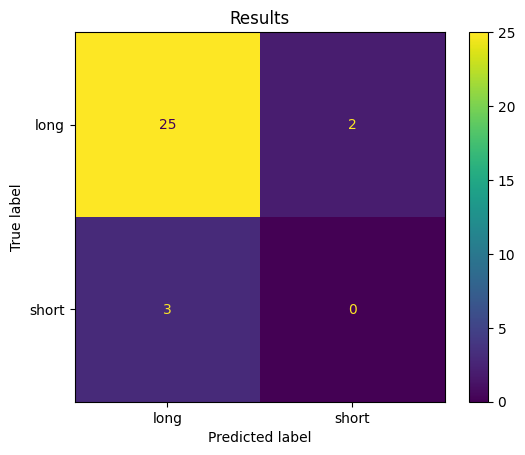

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

X = radiomic_features_df.loc[:,radiomic_features_df.columns != "OS_result"]  #independent columns
y = radiomic_features_df.loc[:,radiomic_features_df.columns == "OS_result"]  #target column i.e price range
df1 = pd.get_dummies(X['sex'])
X = pd.concat([X, df1], axis=1).reindex(X.index)
X.drop('sex', axis=1, inplace=True)
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=33,test_size=0.4)
pca = decomposition.PCA()
std_slc = StandardScaler()
model = LogisticRegression()
pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('pca', pca),
                           ('logistic_Reg', model)])

cv = KFold(n_splits=10,shuffle=True)
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']
n_components = list(range(1,X.shape[1]+1,1))
parameters = dict(pca__n_components=n_components,
                      logistic_Reg__C=C,
                      logistic_Reg__penalty=penalty)
grid_search = GridSearchCV(pipe, parameters)

grid_search.fit(X_train, y_train)
predicted_probs =grid_search.predict_proba(X_test)
print(predicted_probs[0:3])
print (grid_search.best_score_, grid_search.best_params_) 
y_pred = grid_search.predict(X_test)
print(y_pred)
print('\n')
disp = ConfusionMatrixDisplay.from_predictions(
       y_test,y_pred,display_labels=["long","short"]
    )
disp.ax_.set_title("Results")